<a href="https://colab.research.google.com/github/EdiBERT4ImageManipulation/EdiBERT/blob/main/EdiBERT_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/
!git clone https://github.com/EdiBERT4ImageManipulation/EdiBERT
%cd EdiBERT
!mkdir -p logs
%cd logs

!curl -L -o '2021-10-14T16-32-28_ffhq_transformer_bert_2D.tar.gz' 'https://drive.google.com/uc?id=1YGDd8XyycKgBp_whs9v1rkYdYe4Oxfb3&confirm=t'
!curl -L -o '2021-04-23T18-19-01_ffhq_vqgan.tar.gz' 'https://drive.google.com/uc?id=1P_wHLRfdzf1DjsAH_tG10GXk9NKEZqTg&confirm=t'
!tar -xvzf 2021-04-23T18-19-01_ffhq_vqgan.tar.gz
!tar -xvzf 2021-10-14T16-32-28_ffhq_transformer_bert_2D.tar.gz
!rm *.tar.gz 

%cd /content/
!git clone https://github.com/chail/latent-composition
%cp -r latent-composition/utils EdiBERT/ 
%cd EdiBERT

/content
Cloning into 'EdiBERT'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 189 (delta 14), reused 28 (delta 6), pack-reused 146
Receiving objects: 100% (189/189), 31.17 MiB | 30.90 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/EdiBERT
/content/EdiBERT/logs
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4538M  100 4538M    0     0   112M      0  0:00:40  0:00:40 --:--:--  132M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  254M  100  254M    0     0  94.9M      0  0:00:02  0:00:02 --:

In [ ]:
%cd /content/EdiBERT 
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops transformers
%pip install lpips matplotlib

/content/EdiBERT


In [ ]:
from IPython.display import clear_output
import time
from omegaconf import OmegaConf
import yaml
from taming.models.bert_transformer import BertTransformer
import torch
import yaml
import torch
import numpy as np
from scipy import ndimage
import torchvision
import lpips

config_path = "./logs/2021-10-14T16-32-28_ffhq_transformer_bert_2D/configs/2021-10-14T16-32-28-project.yaml"
config = OmegaConf.load(config_path)
model = BertTransformer(**config.model.params)
ckpt_path = "./logs/2021-10-14T16-32-28_ffhq_transformer_bert_2D/checkpoints/epoch=000019.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model.cuda().eval()
torch.set_grad_enabled(True)

l_perceptual = lpips.LPIPS(net='vgg').to(model.device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-04-23T18-19-01_ffhq_vqgan/checkpoints/vqgan.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


# **Observe reconstruction capabilities of (VQGAN) vs (VQGAN + perceptual optimization).**

Choose idx from 0 to 9, number of optim_steps and observe reconstructions.

torch.Size([1, 3, 256, 256])
z_code torch.Size([1, 256, 16, 16]) torch.float32
z_indices torch.Size([1, 256]) torch.int64
Reconstructed image + optim with optim_steps =  100



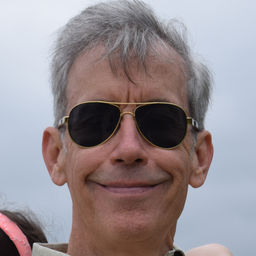
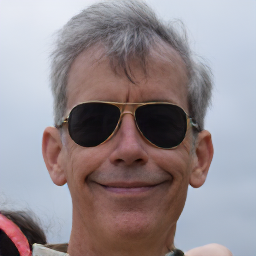
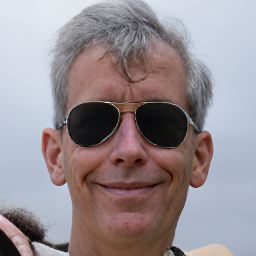

In [ ]:
from PIL import Image
import numpy as np
from torch.autograd import Variable
from utils import show, renormalize, pbar, util, paintwidget, labwidget, imutil

optim_steps = 100
idx = 2

path = "./data/ffhq.txt"
with open(path) as f:
    img_path = f.readlines()

img_path = "./data/ffhq/" + img_path[idx].replace('\n','')

img = Image.open(img_path)
img = np.array(img)
img = torch.tensor(img.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
img = img/127.5-1
img = torch.nn.functional.interpolate(img, size=(256))
print(img.shape)

z_code, z_indices = model.encode_to_z(img)
print("z_code", z_code.shape, z_code.dtype)
print("z_indices", z_indices.shape, z_indices.dtype)
assert z_code.shape[2]*z_code.shape[3] == z_indices.shape[1]
img_rec = model.first_stage_model.decode(z_code)

#Choose number of optimization steps.
print('Reconstructed image + optim with optim_steps = ',optim_steps)
xz = img_rec.detach()
if optim_steps > 0:
    z = Variable(z_code.data,requires_grad=True)
    optimizer = torch.optim.AdamW([z], lr=0.1)
    for j in range(optim_steps):
        xz_j = model.first_stage_model.decode(z)
        loss = l_perceptual(xz_j,img) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    xz = xz_j
    img_rec_optim = model.first_stage_model.decode(z)

show.a(['Source img Input', renormalize.as_image((img.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
show.a(['VQGAN + optimization ', renormalize.as_image(( img_rec_optim.cpu() )[0]).resize((256, 256), Image.ANTIALIAS)])
show.a(['VQGAN', renormalize.as_image((img_rec.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
show.flush()

In [ ]:
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import torchvision

def get_mask_and_sampled_tokens(img, mask, dilation_sampling, dilation_masking):    
    mask_interpolation = torch.nn.functional.interpolate(mask, (16), mode='bilinear')[:,0,:]
    mask_interpolation = (mask_interpolation > 0.1).float()
    mask_interpolation_np = mask_interpolation.cpu().numpy()

    if dilation_sampling>0:
        diff_mask = 1-ndimage.binary_dilation(1-mask_interpolation_np, iterations=dilation_sampling).astype(mask_interpolation_np.dtype)#.flatten()
    elif dilation_sampling<0:
        diff_mask = ndimage.binary_dilation(mask_interpolation_np, iterations=-dilation_sampling).astype(mask_interpolation_np.dtype)
    else:
        diff_mask = mask_interpolation_np

    unsampled_tokens = np.where(diff_mask[0].flatten()==1)[0]
    sampled_tokens = np.where(diff_mask[0].flatten()==0)[0]

    if dilation_masking>0:
        mask_interpolation_np = 1-ndimage.binary_dilation(1-mask_interpolation_np, iterations=dilation_masking).astype(mask_interpolation_np.dtype)#.flatten()
    elif dilation_masking<0:
        mask_interpolation_np = ndimage.binary_dilation(mask_interpolation_np, iterations=-dilation_masking).astype(mask_interpolation_np.dtype)
    mask_interpolation = torch.from_numpy(mask_interpolation_np).to(model.device)
    mask_interpolation = mask_interpolation.view(mask_interpolation.shape[0],-1)
    return mask_interpolation, mask_interpolation_np, diff_mask, sampled_tokens

def img_tensor(filepath,mask=False):
    img = Image.open(filepath).convert('RGB')
    img_np = np.array(img)
    #segmentation = np.eye(182)[segmentation]
    img = torch.tensor(img_np.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
    if mask:
        img = img/255
    else:
        img = img/127.5-1
    img = torch.nn.functional.interpolate(img, size=(256))
    return img, img_np

In [ ]:
def image_editing_with_BERT(img, mask, top_k = 100, nb_epoch = 2, optim_steps = 200):
    progressive_ordering = False
    random_ordering = True
    gaussian_smoothing = True
    erase_mask_influence = False
    mask_inference_token = False
    masked_attention = False
    attention_mask = None
    mask_collage = True
    dilation_masking = 0
    dilation_sampling = 1

    img = img.repeat(1,1,1,1)
    mask = mask.repeat(1,1,1,1)

    mask_interpolation, mask_interpolation_np, diff_mask, sampled_tokens = \
        get_mask_and_sampled_tokens(img, mask, dilation_sampling, dilation_masking)

    

    update_every = 32
    multiple_change = 1
    nb_updates_per_epoch = int(sampled_tokens.shape[0] / multiple_change) + 1
    collage_every = int(nb_updates_per_epoch/5)
    temperature = 1
    temperature_position = 1.

    z_code, z_indices = model.encode_to_z(img)
    _, c_indices = model.encode_to_c(img)

    if progressive_ordering:
        sampled_tokens_progressive = []
        prev_diff_mask = diff_mask
        while True:
            diff_mask = ndimage.binary_dilation(diff_mask, iterations=1).astype(mask_interpolation_np.dtype)
            dilated_area = diff_mask-prev_diff_mask
            prev_diff_mask = diff_mask
            sampled_tokens_i = np.where(dilated_area[0].flatten()==1)[0]
            for st_i in sampled_tokens_i:
                sampled_tokens_progressive.append(st_i )
            if np.sum(1-diff_mask) == 0:
                break
        sampled_tokens = np.array(sampled_tokens_progressive)

    if gaussian_smoothing:
        sigma = 10
        kernel_size = 5
        blurrer = torchvision.transforms.GaussianBlur(kernel_size=(kernel_size,kernel_size), sigma=(sigma,sigma))
        mask = mask.cpu().numpy()
        mask = 1-ndimage.binary_dilation(1-mask, iterations=int(kernel_size/2)).astype(mask_interpolation_np.dtype)
        mask = torch.from_numpy(mask).to(device=model.device)
        mask_gaussian = 1-blurrer(1-mask)
        mask = torch.min(mask_gaussian, mask)

    if erase_mask_influence:
        mask_interpolation = mask_interpolation.view(mask_interpolation.shape[0],-1)
        r_indices = torch.randint_like(z_indices, 0, model.transformer.config.vocab_size)
        z_indices = z_indices.long()
        z_indices = mask_interpolation.long()*z_indices + (1-mask_interpolation).long()*r_indices

    idx = z_indices.reshape(z_code.shape[0],z_code.shape[2],z_code.shape[3])

    for e in range(nb_epoch):
        if random_ordering:
            np.random.shuffle(sampled_tokens)

        for u in range(nb_updates_per_epoch):        
            if mask_collage and u%collage_every == 0 and (nb_updates_per_epoch - u >= collage_every):
                check_mask_token = (idx ==  model.transformer.config.vocab_size)
                xz = model.decode_to_img(idx, z_code.shape)

                xz_mask = img * mask + (1-mask) * (xz)

                z_code,z_indices = model.encode_to_z(xz_mask)
                z_indices = z_indices.reshape(z_code.shape[0],z_code.shape[2],z_code.shape[3])
                z_indices = z_indices.reshape(z_indices.shape[0],-1)
                idx = z_indices

            k = e*nb_updates_per_epoch + u
            z_indices = idx.reshape(idx.shape[0],-1)

            if mask_inference_token:
                for m in range(multiple_change):
                    jm = (k*multiple_change+m)%(sampled_tokens.shape[0])
                    idx_change = sampled_tokens[jm]
                    z_indices[:, idx_change] = torch.randint(model.transformer.config.vocab_size,(1,))

            cz_indices = torch.cat((c_indices, z_indices), dim=1)
            logits, _ = model.transformer.forward_with_mask(cz_indices[:, :],mask=attention_mask)
            logits = logits[:,c_indices.shape[1]:,]
            logits = logits/temperature
            probs = torch.nn.functional.softmax(logits, dim=-1) 

            idx = idx.reshape(idx.shape[0],-1)
            
            for m in range(multiple_change):
                jm = (k*multiple_change+m)%(sampled_tokens.shape[0])
                idx_change = sampled_tokens[jm]                

                logits_s_idx = logits[:,idx_change,:]
                if top_k is not None:
                    logits_s_idx = model.top_k_logits(logits_s_idx, top_k)
                probs = torch.nn.functional.softmax(logits_s_idx, dim=-1)
                ix = torch.multinomial(probs, num_samples=1)  ## shape: batch_size X 1
                idx[:,idx_change] = ix[:,0]

            idx = idx.reshape(z_code.shape[0],16,16)

            if (k%update_every==0 or k==z_code.shape[2]*z_code.shape[3]-1) and k!=0:
                x_sample = model.decode_to_img(idx, z_code.shape)
    
    z = idx.reshape(idx.shape[0],-1)
    z = torch.nn.functional.one_hot(z, 1024).float()
    z = z @ model.first_stage_model.quantize.embedding.weight
    z = z.view([-1, 16, 16, 256]).permute(0, 3, 1, 2)
    xz = model.first_stage_model.decode(z).detach()
    if optim_steps > 0:
        z = Variable(z.data,requires_grad=True)
        optimizer = torch.optim.AdamW([z], lr=0.1)
        for j in range(optim_steps):
            xz_j = model.first_stage_model.decode(z)
            loss = (l_perceptual(xz_j*mask,img*mask) + l_perceptual(xz_j*(1-mask),xz*(1-mask))).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        xz = xz_j
    x_sample = xz
    return x_sample

# **EdiBERT on edited images (image composition)*texte en italique*.**
Choose idx from 0 to 9 and play with EdiBERT's parameters (top-k, nb_epoch, nb_optim_steps..).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



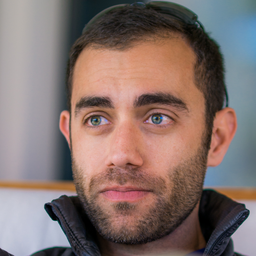
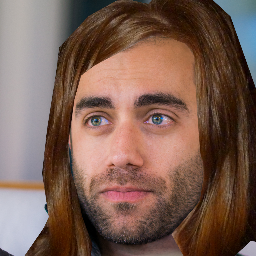
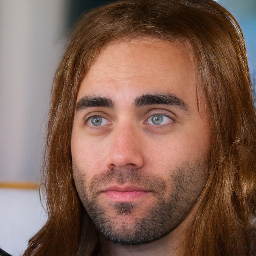

In [ ]:
##### LOADING IMAGES #####
idx = 1

path = "./data/ffhq_collages.txt"
with open(path) as f:
    img_path = f.readlines()

img_path_original = "./data/ffhq/" + img_path[idx].replace('\n','')
source_img, _ = img_tensor(img_path_original)

img_path_edit = "./data/ffhq_collages/" + img_path[idx].replace('\n','')
edit_img, _ = img_tensor(img_path_edit)

img_path_mask = "./data/ffhq_collages_masks/" + img_path[idx].replace('\n','')
mask, _ = img_tensor(img_path_mask, mask=True)



##### Compute EDIBERT projection #####
top_k = 100
nb_epoch = 1
nb_optim_steps = 50
nb_img = 1

edit_img_batch = edit_img.repeat(nb_img,1,1,1)
mask_batch = mask.repeat(nb_img,1,1,1)
edibert_batch = image_editing_with_BERT(edit_img_batch,mask_batch,top_k,nb_epoch,nb_optim_steps)


show.a(['Source img Input', renormalize.as_image((source_img.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
show.a(['Edited Input', renormalize.as_image((edit_img.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
for i in range(nb_img):
  edibert = edibert_batch[i].unsqueeze(0)
  show.a(['EdiBERT '+str(i), renormalize.as_image(( edibert.cpu() )[0]).resize((256, 256), Image.ANTIALIAS)])
show.flush()

# **EdiBERT on edited images (scribble-based edits).**
Choose idx from 0 to 9 and play with EdiBERT's parameters (top-k, nb_epoch, nb_optim_steps..).

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



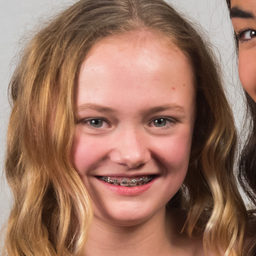
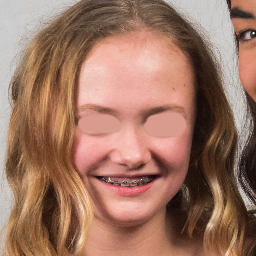
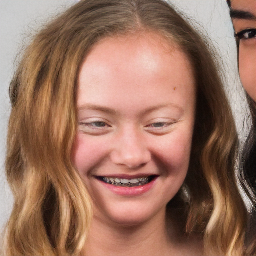

In [ ]:
##### LOADING IMAGES #####
idx = 0

path = "./data/ffhq_edits.txt"
with open(path) as f:
    img_path = f.readlines()

img_path_original = "./data/ffhq/" + img_path[idx].replace('\n','')
source_img, _ = img_tensor(img_path_original)

img_path_edit = "./data/ffhq_edits/" + img_path[idx].replace('\n','')
edit_img, _ = img_tensor(img_path_edit)

img_path_mask = "./data/ffhq_edits_masks/" + img_path[idx].replace('\n','')
mask, _ = img_tensor(img_path_mask, mask=True)



##### Compute EDIBERT projection #####
top_k = 100
nb_epoch = 1
nb_optim_steps = 50
nb_img = 1

edit_img_batch = edit_img.repeat(nb_img,1,1,1)
mask_batch = mask.repeat(nb_img,1,1,1)
edibert_batch = image_editing_with_BERT(edit_img_batch,mask_batch,top_k,nb_epoch,nb_optim_steps)


show.a(['Source img Input', renormalize.as_image((source_img.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
show.a(['Edited Input', renormalize.as_image((edit_img.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
for i in range(nb_img):
  edibert = edibert_batch[i].unsqueeze(0)
  show.a(['EdiBERT '+str(i), renormalize.as_image(( edibert.cpu() )[0]).resize((256, 256), Image.ANTIALIAS)])
show.flush()

# **Online scribble-editing + EdiBERT projection.** 
Choose idx from 0 to 9, make a scribble-edit and play with EdiBERT's parameters (top-k, nb_epoch, nb_optim_steps..).


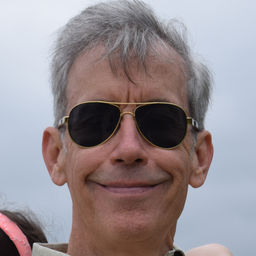
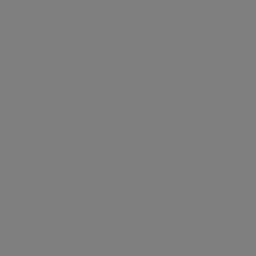
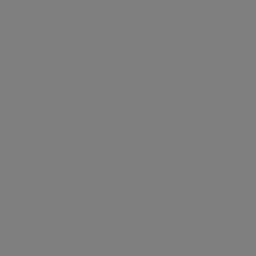

In [ ]:
idx = 2
COLOR = 'black' ## Choose between: lime, red, blue, yellow, light_grey, brown, light_skin, dark_skin, lips, white, black

path = "./data/ffhq.txt"
with open(path) as f:
    img_path = f.readlines()

img_path = "./data/ffhq/" + img_path[idx].replace('\n','')

source_im, img_np = img_tensor(img_path)

outdim = 256
src_painter = paintwidget.PaintWidget(oneshot=False, width=256, height=256, 
                                      brushsize=4, save_sequence=False, track_move=True) # , on_move=True)
src_painter.image = renormalize.as_url(source_im[0], size=256)

img_url = renormalize.as_url(torch.zeros(3, 256, 256))
img_html = '<img src="%s"/>'%img_url
output_div = labwidget.Div(img_html)

counter = 0
prev_time = time.time()
update_freq = 1 # mouse time intervals;  
# decrease update_freq to reduce lagging, but colab is kind of slow
mask_list = []
edit_list = []

if COLOR == 'lime':
    pixel = [0,255,0]
elif COLOR == 'red':
    pixel = [255,0,0] 
elif COLOR == 'blue':
    pixel = [0,0,255]
elif COLOR == 'yellow':
    pixel = [255,255,0]
elif COLOR == 'light_grey':
  pixel = [160,160,160]
elif COLOR == 'brown':
  pixel = [102,60,0]
elif COLOR == 'light_skin':
  pixel = [198.0, 152.0, 134.0]
elif COLOR == 'dark_skin':
  pixel = [146.0000, 107.0000, 81.0000]
elif COLOR == 'lips':
  pixel = [210.0000, 160.0000, 160.0000]
elif COLOR == 'white':
  pixel = [255,255,255]
elif COLOR == 'black':
  pixel = [0,0,0]

pixel = [p / 127.5 - 1 for p in pixel]


color_img = torch.FloatTensor(pixel).unsqueeze(0).unsqueeze(2).unsqueeze(3)
color_img = color_img.repeat(1,1,256,256).to(model.device)


def probe_changed(c):
    global counter
    global prev_time
    counter += 1
    curr_time = time.time()
    if curr_time - prev_time < update_freq:
        return
    prev_time = time.time()
    
    mask_url = src_painter.mask_buffer
    mask =  renormalize.from_url(mask_url, target='pt', size=(outdim, outdim)).cuda()[None] # 1x3xHxW
    mask = mask[:, [0], :, :] # 1x1xHxW
    mask_list.append(mask)
    edited_im = source_im * (1-mask) + mask * color_img
    edit_list.append(edited_im)
    img_url = renormalize.as_url(edited_im[0], size=256)
    img_html = '<img src="%s"/>'%img_url
    output_div.innerHTML = img_html
    
src_painter.on('mask_buffer', probe_changed)

show.a([src_painter], cols=2)
show.a([output_div], cols=2)

show.flush()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



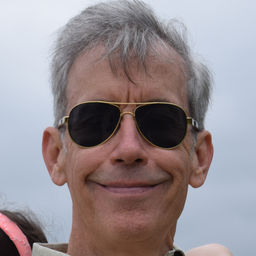
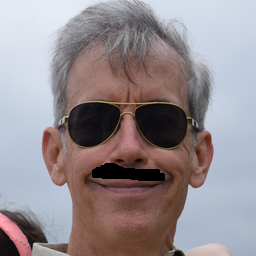
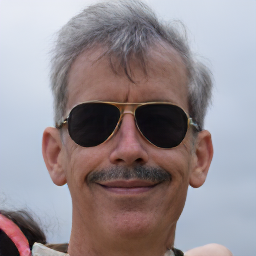
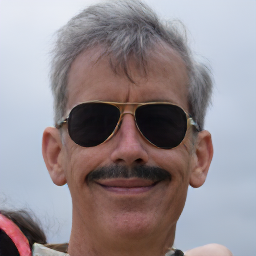

In [ ]:
mask = (1-mask_list[-1])
edit_img = edit_list[-1]
top_k = 100
nb_epoch = 1
nb_optim_steps = 50
nb_img = 2

edit_img_batch = edit_img.repeat(nb_img,1,1,1)
mask_batch = mask.repeat(nb_img,1,1,1)
edibert_batch = image_editing_with_BERT(edit_img_batch,mask_batch,top_k,nb_epoch,nb_optim_steps)

show.a(['Source img Input', renormalize.as_image((source_im.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
show.a(['Edited Input', renormalize.as_image((edit_img.cpu())[0]).resize((256, 256), Image.ANTIALIAS)])
for i in range(nb_img):
  edibert = edibert_batch[i].unsqueeze(0)
  show.a(['EdiBERT '+str(i), renormalize.as_image(( edibert.cpu() )[0]).resize((256, 256), Image.ANTIALIAS)])
show.flush()
